In [1]:

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# adding normal distributed noise to image
def add_noise(img, mean=0, sigma=0.3):
    noisy_img = img + torch.normal(mean * torch.ones(img.shape), sigma)
    return noisy_img.clamp(0,1)

# function to count model parameters that are adjusted during training
def model_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# evaluation function for specified dataset
def eval_model(model, data_loader, criterion, device):
  with torch.no_grad():
      model.eval()

      loss_list = []
      loss_recons = []
      loss_kld = []

      #loss, (recons_loss, kld)

      for images, labels, l in data_loader:
          nimages = add_noise(images)
          nimages = nimages.to(device)
          images = images.to(device)
          labels = labels.to(device)

          outputs, (z, mu, log_var) = model((nimages, labels))

          loss, (recons_l, kld_l) = criterion(outputs, images, mu, log_var)
          loss_list.append(loss.item())
          loss_recons.append(recons_l.cpu().numpy())
          loss_kld.append(kld_l.cpu().numpy())

      loss = np.mean(loss_list)
      recons = np.mean(loss_recons)
      kld = np.mean(loss_kld)

      model.train()
      return loss, (recons, kld)



#
from tqdm import tqdm

def train(model, NUM_EPOCHS, train_loader, test_loader, optimizer, criterion, EVAL_FREQ, SAVE_FREQ, savepath, device, scheduler, twriter = None, loadpath = None, stats = None):

  if loadpath != None:
    model, optimizer, init_epoch, stats = load_model(model, optimizer, loadpath)
    print('loaded model: ' + loadpath)
  elif stats != None:
     stats = stats
     init_epoch = 0
  else:
    stats = {
    "epoch": [],
    "full_train_loss": [],
    "train_loss": [],
    "valid_loss": [],
    "valid_loss_recons": [],
    "valid_loss_kld": [],
    "per_batch_loss": [],
    }
    init_epoch = 0

  model.to(device)
  model.train()

  loss_hist = []
  best_acc = 0
  #current_lr = scheduler.get_last_lr()[0]

  valid_loss, (recons, kld) = eval_model(model, test_loader, criterion, device)

  stats["valid_loss"].append(valid_loss)
  stats["valid_loss_recons"].append(recons)
  stats["valid_loss_kld"].append(kld)

  if len(stats["epoch"]) == 0:
      stats["epoch"].append(0)
  else:
      stats["epoch"].append(stats["epoch"][-1]+1)
  print(f"Epoch -1: valid_loss {valid_loss:.5f}")# | lr {current_lr}")

  for epoch in range(init_epoch, NUM_EPOCHS):
      loss_list = []
      progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
      for i, (images, labels, l) in progress_bar:
          nimages = add_noise(images)
          images = images.to(device)
          nimages = nimages.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()

          outputs, (z, mu, log_var) = model((nimages, labels))

          loss, _ = criterion(outputs, images, mu, log_var)
          loss_list.append(loss.item())
          stats["per_batch_loss"].append(loss.cpu().detach().numpy())

          loss.backward()

          optimizer.step()

          progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")

      loss_hist.append(np.mean(loss_list))
      stats["epoch"].append(stats["epoch"][-1]+1)
      stats["full_train_loss"].append(loss_hist[-1])
      if twriter != None:
         twriter.add_scalar(f'Full Loss', stats["full_train_loss"][-1], global_step=stats["epoch"][-1])

      if epoch % EVAL_FREQ == 0:
          valid_loss, (recons, kld) = eval_model(model, test_loader, criterion, device)
          stats["valid_loss"].append(valid_loss)
          stats["valid_loss_recons"].append(recons)
          stats["valid_loss_kld"].append(kld)
          if twriter != None:
            twriter.add_scalar(f'Loss/Valid', valid_loss, global_step=stats["epoch"][-1])

          print(f"Epoch {epoch+1}: train_loss {np.mean(loss_list):.5f} | valid_loss {valid_loss:.5f}")#| lr {current_lr}")


      if epoch % SAVE_FREQ == 0:
          save_model(model=model, optimizer=optimizer, epoch=epoch, stats=stats, path=savepath, best=False)

      scheduler.step(stats["valid_loss"][-1])
      #current_lr = scheduler.get_last_lr()[0]


  return stats, model

# function to make loss smooth
def smooth(f, K=5):
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]
    return smooth_f


# functions to save model/stats and load them
import os

def save_model(model, optimizer, epoch, stats, path, best=False):
    if(not os.path.exists(path + "/models")):
        os.makedirs(path + "/models")
    if best:
        savepath = path + '/' + f"models/best_model.pth"
    else:
        savepath = path + '/' + f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):

    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]

    return model, optimizer, epoch, stats


# function to evaluate cnn model and plot results
def eval_plots(model, test_loader, criterion, device, stats):
  eval_loss, (recons, kld) = eval_model(model, test_loader, criterion, device)

  epochs = np.array(stats["epoch"])-1
  train_loss = np.array(stats["full_train_loss"])
  valid_loss = np.array(stats["valid_loss"])
  rec_loss = np.array(stats["valid_loss_recons"])
  kld_loss = np.array(stats["valid_loss_kld"])

  # show loss curves and accuracy
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  ax[0].plot(train_loss, label="train loss")
  ax[0].plot(epochs, valid_loss, label="valid loss")
  ax[0].set_xlabel("Epoch")
  ax[0].set_ylabel("Loss")
  ax[0].set_title("Loss curves (train/validation)")
  ax[0].legend()
  ax[0].grid()

  ax[1].plot(epochs, valid_loss, label="total loss")
  ax[1].plot(epochs, rec_loss, label="recons loss")
  ax[1].plot(epochs, kld_loss, label="KLD loss")
  ax[1].set_xlabel("Epoch")
  ax[1].set_ylabel("Loss")
  ax[1].set_title("Independent Loss Curves")
  ax[1].legend()
  ax[1].set_yscale("log")
  ax[1].grid()

  plt.show()

def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return


def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-3):
    mu = mu.reshape(recons.shape[0], -1)
    log_var = log_var.reshape(recons.shape[0], -1)
    recons_loss = nn.functional.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [2]:
import numpy as np
import torch
print(torch.__version__)

from tqdm import tqdm
import matplotlib.pyplot as plt

#from torch.utils.tensorboard import SummaryWriter

2.0.1+cu118


In [3]:
#from utils import eval_model, train, smooth, save_model, load_model, model_params, eval_plots, set_random_seed, eval_model_conf

In [3]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

import os
import shutil

In [4]:
# choose device to be used depending on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
import os
import random
from PIL import Image
import torch
import torchvision.transforms as transforms

class DatasetWrapper(torch.utils.data.Dataset):

  def __init__(self, dataset, n_classes = 101):
    self.dataset = dataset
    self.n_classes = n_classes


  def __getitem__(self, x):
    inst_tensor, label = self.dataset.__getitem__(x)
    label_tensor = torch.zeros(self.n_classes)
    label_tensor[label] = 1

    return inst_tensor, label_tensor, label

  def __len__(self):
    return self.dataset.__len__()


In [103]:
"""
train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size = 257, scale = (0.3, 1)),
            transforms.ToTensor(),
            ])

test_transforms = transforms.Compose([
            transforms.CenterCrop(257),
            transforms.ToTensor(),
            ])

dset_direc = 'Food101'

p_train_dataset = torchvision.datasets.Food101(root = dset_direc, split = 'train', transform = train_transforms, download = True)
p_test_dataset = torchvision.datasets.Food101(root = dset_direc, split = 'test', transform = test_transforms, download = True)

train_dataset = DatasetWrapper(p_train_dataset, n_classes = 101)
test_dataset = DatasetWrapper(p_test_dataset, n_classes = 101)

print(f"Train samples: {len(train_dataset)}")

print(f"Test samples: {len(test_dataset)}")
"""

Train samples: 75750
Test samples: 25250


In [6]:
mnist_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((33,33), antialias=False)
    ])

p_train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=mnist_tf,download=True)
p_test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=mnist_tf)

train_dataset = DatasetWrapper(p_train_dataset, n_classes = 10)
test_dataset = DatasetWrapper(p_test_dataset, n_classes = 10)

print(f"Train samples: {len(train_dataset)}")

print(f"Test samples: {len(test_dataset)}")

100%|██████████| 26421880/26421880 [00:01<00:00, 19415682.74it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 345039.18it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6139911.16it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 27057991.22it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train samples: 60000
Test samples: 10000


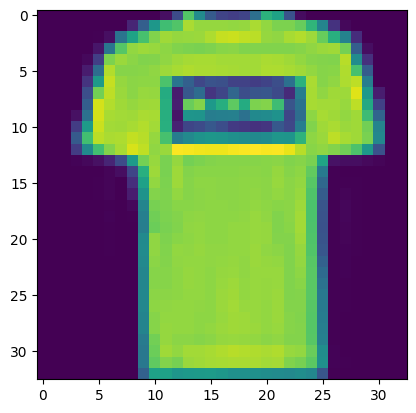

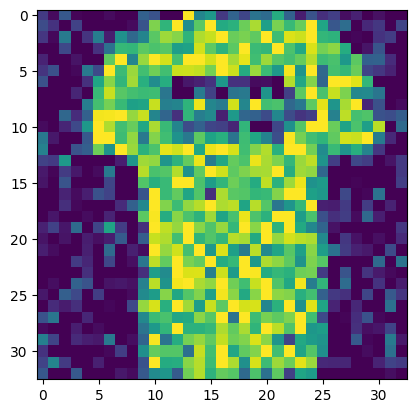

In [7]:
from scipy.misc import face
import matplotlib.pyplot as plt
import torch

instance, label, l = train_dataset.__getitem__(1)

plt.imshow(transforms.functional.to_pil_image(instance))
plt.show()

plt.imshow(transforms.functional.to_pil_image(add_noise(instance, mean=0, sigma=0.2)))
plt.show()

# conditional VAE

In [8]:
class Encoder(nn.Module):
  def __init__(self, sizes = (225,225), channels = [3,10,12,14,16], fc_sizes = [1024, 512, 256], kernel_size = 3, n_classes = 10):
    super().__init__()

    self.kernel_size = kernel_size
    self.channels = channels
    self.fc_sizes = fc_sizes
    self.n_classes = n_classes
    out_size = list(sizes)

    cnn_layers = []
    for i in range(len(self.channels) - 1):
      cnn_layers.append(nn.Dropout(p=0.3))
      cnn_layers.append(nn.Conv2d(self.channels[i], self.channels[i+1], self.kernel_size, stride = 2, padding=int(self.kernel_size/2)))
      cnn_layers.append(nn.ReLU())
      out_size[0] = int(out_size[0]/2)+1
      out_size[1] = int(out_size[1]/2)+1

    self.cnn_layers = nn.Sequential(*cnn_layers)

    fc_layers = []
    for i in range(len(self.fc_sizes)):
      in_size = out_size[0]*out_size[1]*self.channels[-1] + self.n_classes if i == 0 else self.fc_sizes[i-1]
      fc_layers.append(nn.Dropout(p=0.2))
      fc_layers.append(nn.Linear(in_size, self.fc_sizes[i]))
      fc_layers.append(nn.ReLU())

    self.fc_layers = nn.Sequential(*fc_layers)


  def forward(self, x):
    img = x[0]
    label = x[1]
    n_batch, n_channels, h, w = img.shape
    features = self.cnn_layers(img)
    features = features.reshape(n_batch, -1)
    concat_features = torch.cat([features, label], dim = 1)
    x = self.fc_layers(concat_features)
    return x

class Decoder(nn.Module):
  def __init__(self, sizes = (255,255), channels = [16,14,12,10,3], fc_sizes = [256, 512, 1024], kernel_size = 3, n_classes = 10):
    super().__init__()

    self.kernel_size = kernel_size
    self.channels = channels
    self.fc_sizes = fc_sizes
    self.n_classes = n_classes
    out_size = list(sizes)

    cnn_layers = []
    for i in range(len(self.channels) - 1):
      cnn_layers.append(nn.Dropout(p=0.1))
      cnn_layers.append(nn.ConvTranspose2d(self.channels[i], self.channels[i+1], self.kernel_size, stride = 2, padding=int(self.kernel_size/2)))
      cnn_layers.append(nn.ReLU())
      out_size[0] = int(out_size[0]/2)+1
      out_size[1] = int(out_size[1]/2)+1
    cnn_layers[-1] = nn.Sigmoid()
    self.cnn_layers = nn.Sequential(*cnn_layers)

    self.hidden_img_size = out_size

    fc_layers = []
    for i in range(len(self.fc_sizes)):
      in_size = self.fc_sizes[i] + self.n_classes if i == 0 else self.fc_sizes[i]
      out = out_size[0]*out_size[1]*self.channels[0] if i == len(self.fc_sizes)-1 else self.fc_sizes[i+1]
      fc_layers.append(nn.Dropout(p=0.1))
      fc_layers.append(nn.Linear(in_size, out))
      fc_layers.append(nn.ReLU())

    self.fc_layers = nn.Sequential(*fc_layers)

  def forward(self, x):
    features = x[0]
    label = x[1]
    n_batch, depth = features.shape
    concat_features = torch.cat([features, label], dim = 1)
    features = self.fc_layers(concat_features)
    img = features.reshape(n_batch, -1, self.hidden_img_size[0], self.hidden_img_size[0])
    img = self.cnn_layers(img)
    return img

In [9]:
class VAE(nn.Module):
    def __init__(self, input_size = (3,225,225), channels = [3,10,12,14,16], fc_sizes = [1024, 512, 256], kernel_size = 5, n_classes = 10):
        super().__init__()

        self.kernel_size = kernel_size
        self.channels = channels
        self.fc_sizes = fc_sizes
        self.n_classes = n_classes


        self.encoder = Encoder(sizes = input_size[1:], channels = self.channels, fc_sizes = self.fc_sizes[:len(self.fc_sizes)-1], kernel_size = self.kernel_size, n_classes = self.n_classes)
        self.channels.reverse()
        self.fc_sizes.reverse()
        self.decoder = Decoder(sizes = input_size[1:], channels = self.channels, fc_sizes = self.fc_sizes, kernel_size = self.kernel_size, n_classes = self.n_classes)
        self.channels.reverse()
        self.fc_sizes.reverse()

        self.fc_mu = nn.Linear(self.fc_sizes[-2],self.fc_sizes[-1])
        self.fc_sigma = nn.Linear(self.fc_sizes[-2],self.fc_sizes[-1])


    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    def forward(self, x):
        img = x[0]
        label = x[1]
        features = self.encoder((img, label))

        mu = self.fc_mu(features)
        log_var = self.fc_sigma(features)

        features = self.reparameterize(mu, log_var)
        img = self.decoder((features, label))

        return img, (features, mu, log_var)


In [26]:
model = VAE(input_size = (1,33,33), channels = [1,20], fc_sizes = [10, 9, 2], kernel_size = 5, n_classes = 10)

test_image = torch.ones(32,1,33,33)  # for some reason only works with uneven image size (e.g. for 225 correct, not for 224)
test_labels = torch.zeros(32,101)

print(test_image.shape)
print(test_labels.shape)

out, (z, mu, log_var) = model.forward((test_image, test_labels))
print(mu.shape)
print(out.shape)
print(z.shape)

torch.Size([32, 1, 33, 33])
torch.Size([32, 101])
torch.Size([32, 2])
torch.Size([32, 1, 33, 33])
torch.Size([32, 2])


In [27]:
model = VAE(input_size = (1,33,33), channels = [1,16,32], fc_sizes = [1024, 726, 512, 2], kernel_size=5, n_classes = 10)
model.to(device)

VAE(
  (encoder): Encoder(
    (cnn_layers): Sequential(
      (0): Dropout(p=0.3, inplace=False)
      (1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (5): ReLU()
    )
    (fc_layers): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=2602, out_features=1024, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=1024, out_features=726, bias=True)
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Linear(in_features=726, out_features=512, bias=True)
      (8): ReLU()
    )
  )
  (decoder): Decoder(
    (cnn_layers): Sequential(
      (0): Dropout(p=0.1, inplace=False)
      (1): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): ConvTr

In [28]:
print(f"The model has {model_params(model)} parameters.")

The model has 7590705 parameters.


In [29]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-3):
    mu = mu.reshape(recons.shape[0], -1)
    log_var = log_var.reshape(recons.shape[0], -1)
    recons_loss = nn.functional.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [30]:
BATCH_SIZE = 32
SHUFFLE_TRAIN = True
NUM_EPOCHS = 12
LR = 3e-4
EVAL_FREQ = 1
SAVE_FREQ = 2
OPTI_STEPS = 100


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

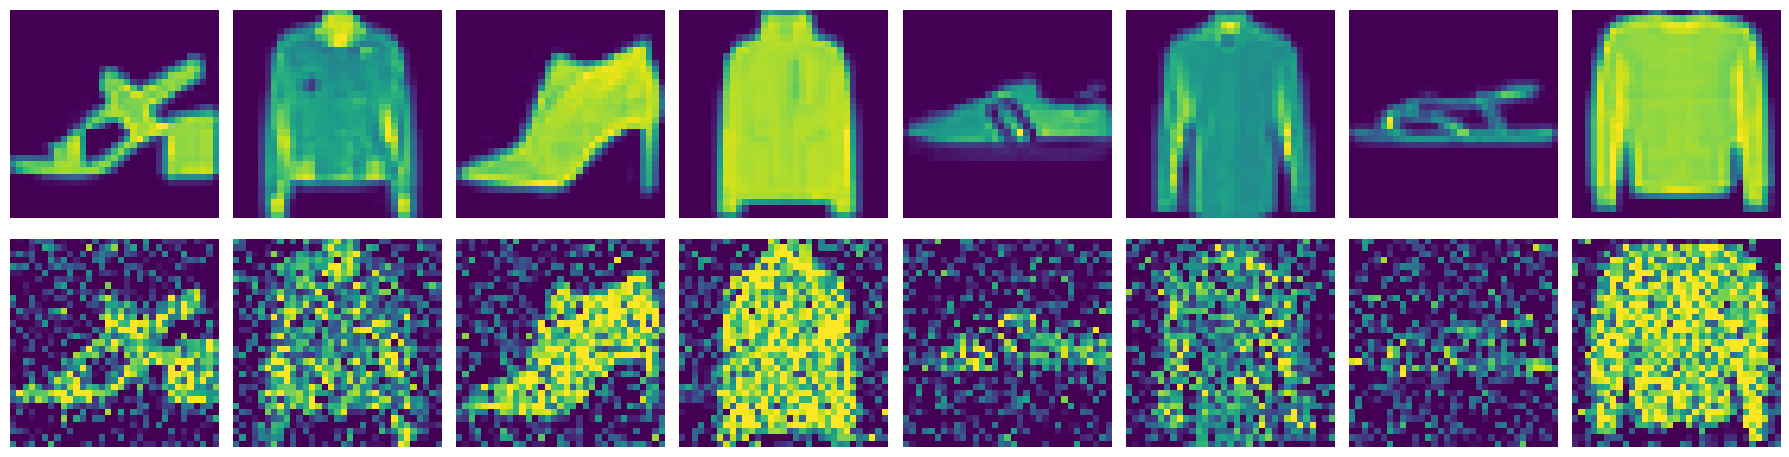

In [31]:
imgs, _, _ = next(iter(train_loader))
noisy_imgs = add_noise(imgs, sigma=0.3)
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    ax[0, i].imshow(transforms.functional.to_pil_image(imgs[i]))
    ax[0, i].axis("off")
    ax[1, i].imshow(transforms.functional.to_pil_image(noisy_imgs[i]))
    ax[1, i].axis("off")
plt.tight_layout()
plt.show()

In [32]:
# classification loss function
criterion = vae_loss_function

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Decay LR by a factor of 0.1 every X epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1, verbose=True)

In [33]:
import time
set_random_seed(420)
start_time = time.time()
stats0, model = train(model, NUM_EPOCHS, train_loader, val_loader, optimizer, criterion, EVAL_FREQ, SAVE_FREQ, '/content', device, scheduler, twriter = None, loadpath = None, stats = None)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch -1: valid_loss 0.16931


Epoch 1 Iter 1875: loss 0.03087. : 100%|██████████| 1875/1875 [03:32<00:00,  8.84it/s]


Epoch 1: train_loss 0.03998 | valid_loss 0.02788


Epoch 2 Iter 1875: loss 0.03249. : 100%|██████████| 1875/1875 [02:48<00:00, 11.13it/s]


Epoch 2: train_loss 0.03175 | valid_loss 0.02824


Epoch 3 Iter 1875: loss 0.02757. : 100%|██████████| 1875/1875 [02:52<00:00, 10.87it/s]


Epoch 3: train_loss 0.03087 | valid_loss 0.02850


Epoch 4 Iter 1875: loss 0.02908. : 100%|██████████| 1875/1875 [04:21<00:00,  7.18it/s]


Epoch 4: train_loss 0.03030 | valid_loss 0.03051


Epoch 5 Iter 1875: loss 0.03228. : 100%|██████████| 1875/1875 [07:17<00:00,  4.28it/s]


Epoch 5: train_loss 0.02995 | valid_loss 0.02914
Epoch 00005: reducing learning rate of group 0 to 3.0000e-05.


Epoch 6 Iter 1875: loss 0.03443. : 100%|██████████| 1875/1875 [07:06<00:00,  4.40it/s]


Epoch 6: train_loss 0.02908 | valid_loss 0.02974


Epoch 7 Iter 1875: loss 0.02832. : 100%|██████████| 1875/1875 [07:10<00:00,  4.35it/s]


Epoch 7: train_loss 0.02891 | valid_loss 0.02903


Epoch 8 Iter 1875: loss 0.03024. : 100%|██████████| 1875/1875 [06:40<00:00,  4.68it/s]


Epoch 8: train_loss 0.02882 | valid_loss 0.02920


Epoch 9 Iter 1875: loss 0.03199. : 100%|██████████| 1875/1875 [04:27<00:00,  7.01it/s]


Epoch 9: train_loss 0.02884 | valid_loss 0.02942
Epoch 00009: reducing learning rate of group 0 to 3.0000e-06.


Epoch 10 Iter 1875: loss 0.03023. : 100%|██████████| 1875/1875 [02:41<00:00, 11.61it/s]


Epoch 10: train_loss 0.02862 | valid_loss 0.02900


Epoch 11 Iter 1875: loss 0.02551. : 100%|██████████| 1875/1875 [03:05<00:00, 10.09it/s]


Epoch 11: train_loss 0.02870 | valid_loss 0.02900


Epoch 12 Iter 1875: loss 0.02943. : 100%|██████████| 1875/1875 [02:58<00:00, 10.48it/s]


Epoch 12: train_loss 0.02865 | valid_loss 0.02919
--- 3434.4270865917206 seconds ---


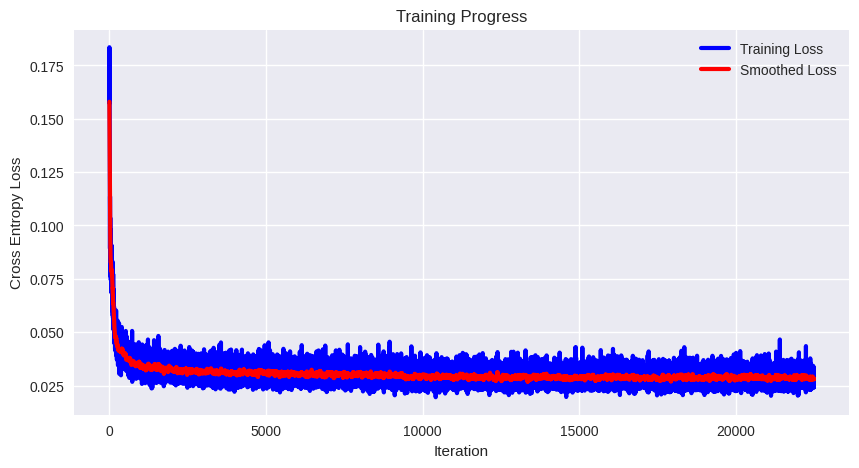

In [34]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,5)

smooth_loss = smooth(stats0["per_batch_loss"], 31)
ax.plot(stats0["per_batch_loss"], c="blue", label="Training Loss", linewidth=3)#, alpha=0.5)
ax.plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax.legend(loc="best")
ax.set_xlabel("Iteration")
ax.set_ylabel("Cross Entropy Loss")
ax.set_title("Training Progress")

plt.show()

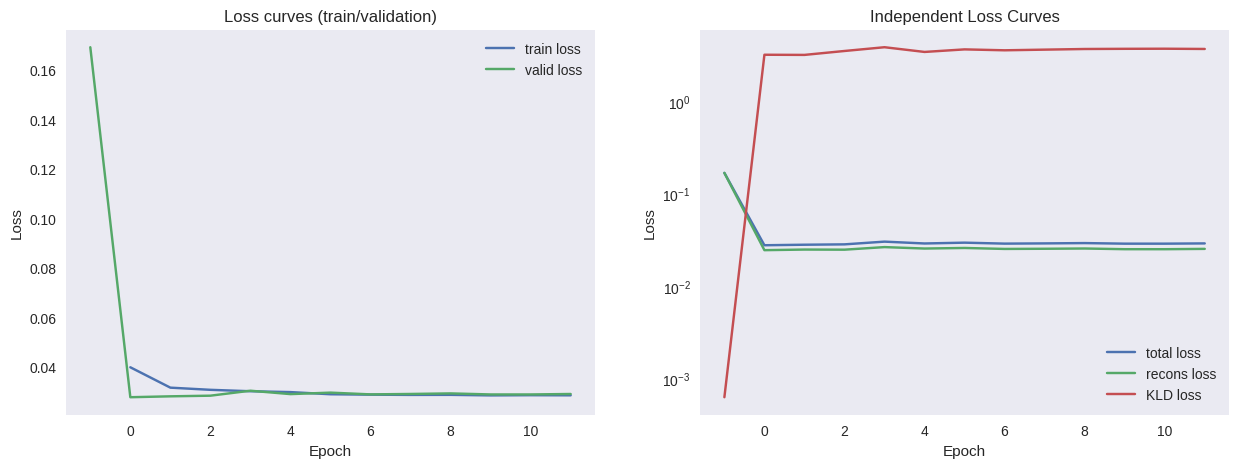

In [35]:
eval_plots(model, val_loader, criterion, device, stats0)

The loss generally look like we expected, decreasing fast in the beginning, than slowing down and converging. It also reaches a quite small value (compared to results with Food101)

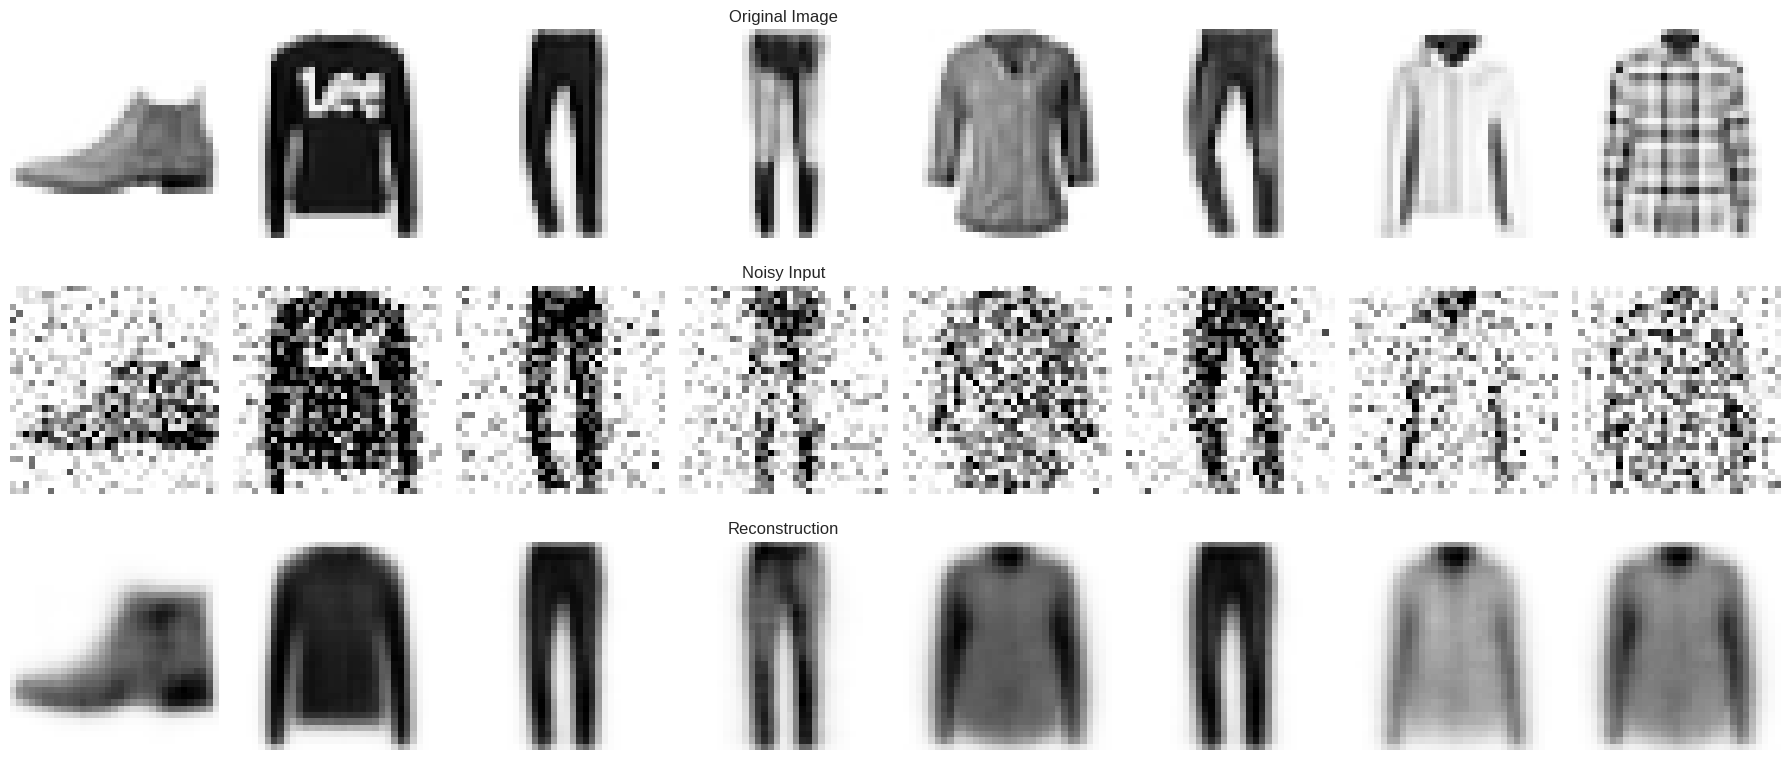

In [36]:
imgs, labels, l = next(iter(val_loader))
noisy_imgs = add_noise(imgs, sigma=0.3)

model.eval()
with torch.no_grad():
    recons, _ = model((noisy_imgs.to(device), labels.to(device)))

fig, ax = plt.subplots(3, 8)
fig.set_size_inches(18, 8)
for i in range(8):
    ax[0, i].imshow(transforms.functional.to_pil_image(imgs[i]))#, cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(transforms.functional.to_pil_image(noisy_imgs[i]))#, cmap="gray")
    ax[1, i].axis("off")
    ax[2, i].imshow(transforms.functional.to_pil_image(recons[i].cpu()))#, cmap="gray")
    ax[2, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Noisy Input")
ax[2, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

Analysis

In [37]:
from sklearn.decomposition import PCA

In [38]:


def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """

    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    #print(legend)
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(6,6))

    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)
        ax.scatter(points[idx, 0], points[idx, 1])#, label=legend[int(l)], c=COLORS[i])
    #ax.legend(loc="best")

In [39]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls, l in val_loader:
        label = lbls.to(device)
        imgs = imgs.to(device)
        _, (z, _, _) = model((imgs, label))
        latents.append(z.cpu())
        labels.append(l)

latents = np.concatenate(latents)
labels = np.concatenate(labels)

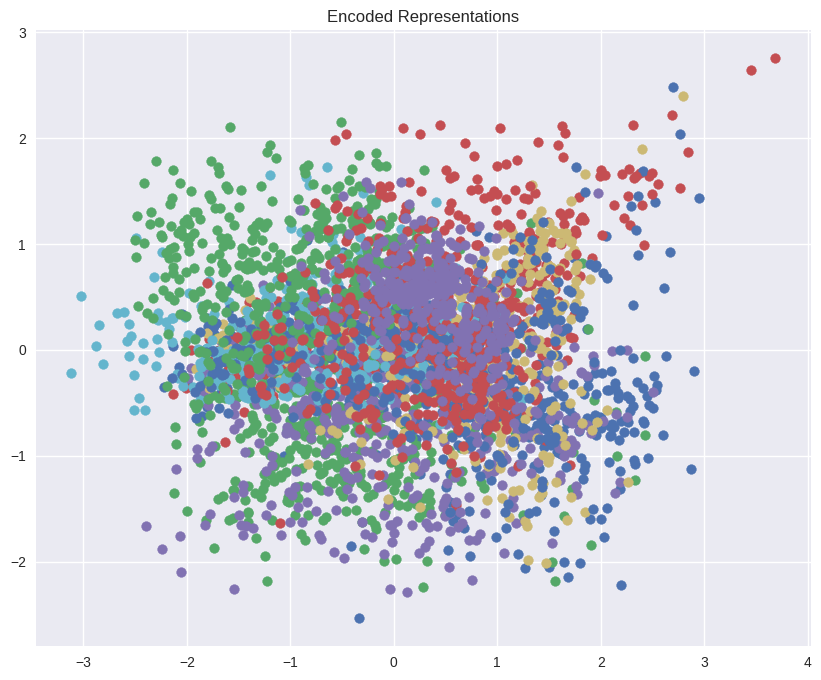

In [42]:
N = 4000
pca_latents = PCA(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,1,figsize=(10,8))
display_projections(pca_latents[:N], labels[:N], ax=ax, legend=None)
ax.set_title("Encoded Representations")
plt.show()

The latent space looks better separated than random noise, but worse than for the normal VAE. This is probably the case because of the influence of the one hot encoded vectors that are also an input for the decoder. Therefore the encoder does not have to learn as much information about the specific class.

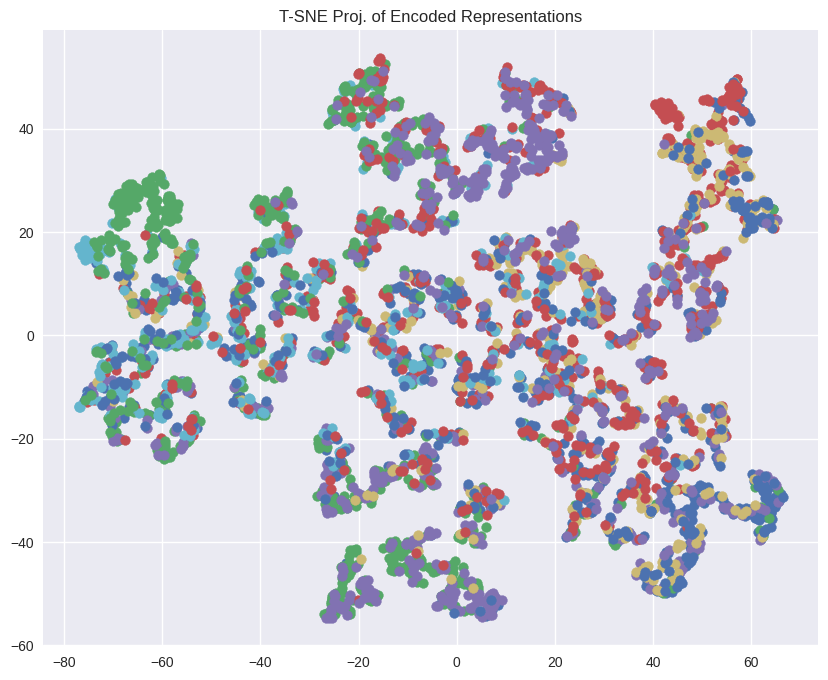

In [41]:
from sklearn.manifold import TSNE

N = 4000
tsne_latents = TSNE(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,1,figsize=(10,8))
display_projections(tsne_latents[:N], labels[:N], ax=ax, legend=None)
ax.set_title("T-SNE Proj. of Encoded Representations")
plt.show()

### Inference

In [43]:
if not os.path.exists("imgs/inferecence_vae"):
    os.makedirs("imgs/inferecence_vae")

In [44]:
from torchvision.utils import save_image

with torch.no_grad():
    for i in range(5):
        label = torch.zeros(64,10).to(device)
        for i in range(64):
          index = np.random.randint(0, high = 10)
          label[i, index] = 1
        z = torch.randn(64, 2).to(device)
        sample = model.decoder((z, label))
        save_image(sample.view(64, 1, 33, 33), f"imgs/inferecence_vae/inference_{i}.png")

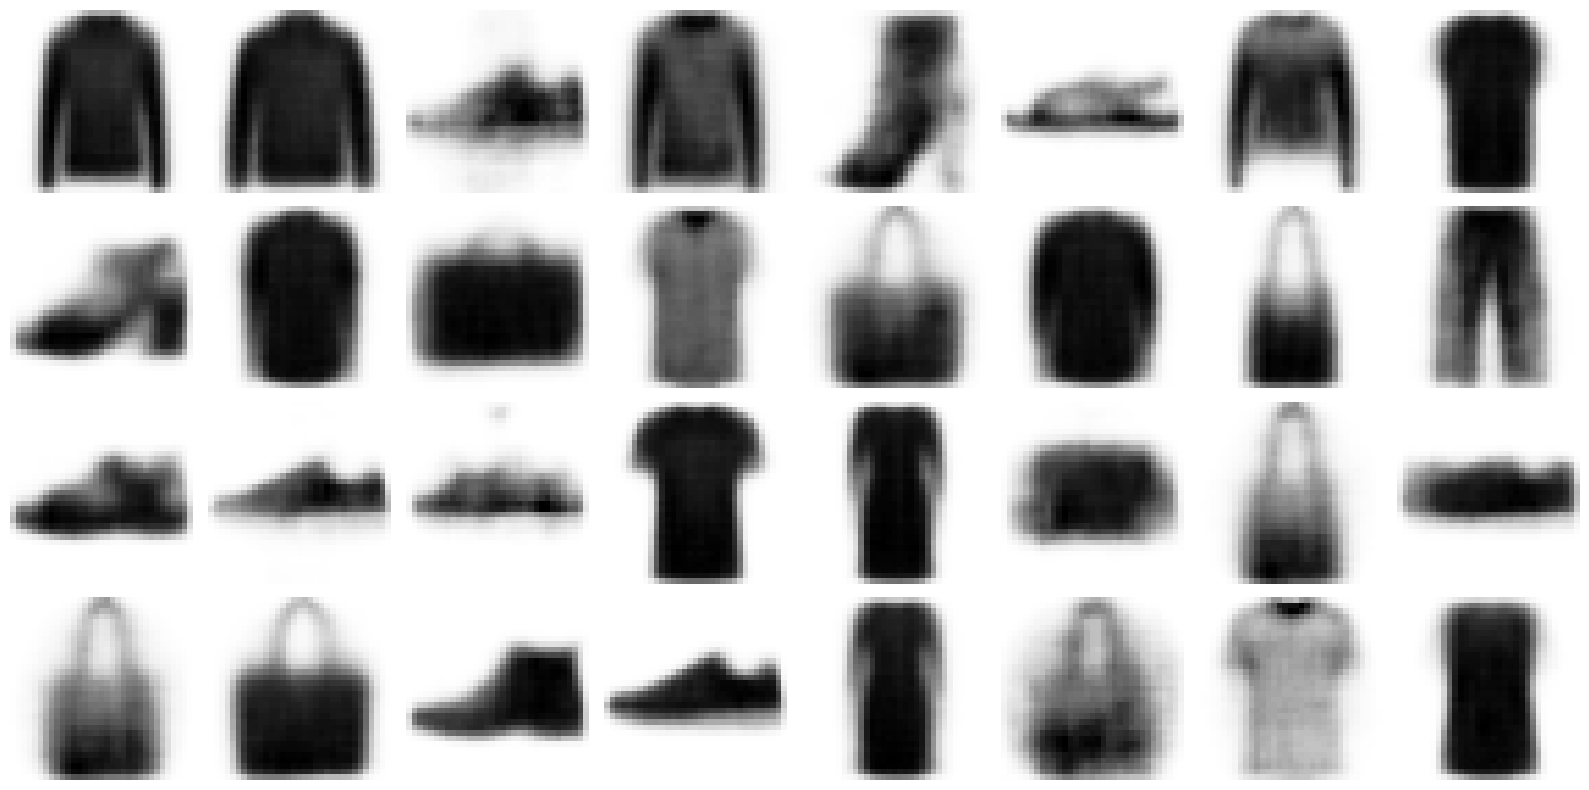

In [45]:
recons = sample.view(64, 1, 33, 33)
plt.figure(figsize=(8*2, 4*2))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(transforms.functional.to_pil_image(recons[i].cpu()))
    plt.axis("off")
plt.tight_layout()
plt.show()

### Interpolation

space for no specific class (one hot encoded vector is 0 everywhere)

In [50]:
@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange,
    decoding latents and visualizing distribution of the space
    """
    SIZE = 33
    grid = np.empty((1,N*SIZE, N*SIZE))

    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(device)
            label = torch.zeros(1,10).to(device)
            x_hat = model.decoder((z, label)).cpu()
            x_hat = x_hat.view(1, 33,33)

            #if np.random.randint(0, high=2) == 1:
            #  x_hat = torch.zeros(3,257,257)

            grid[:,(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat

    grid = torch.tensor(grid)

    plt.figure(figsize=(12,20))
    plt.imshow(transforms.functional.to_pil_image(grid), extent=[*yrange, *xrange])#, cmap="gray")
    plt.axis("off")

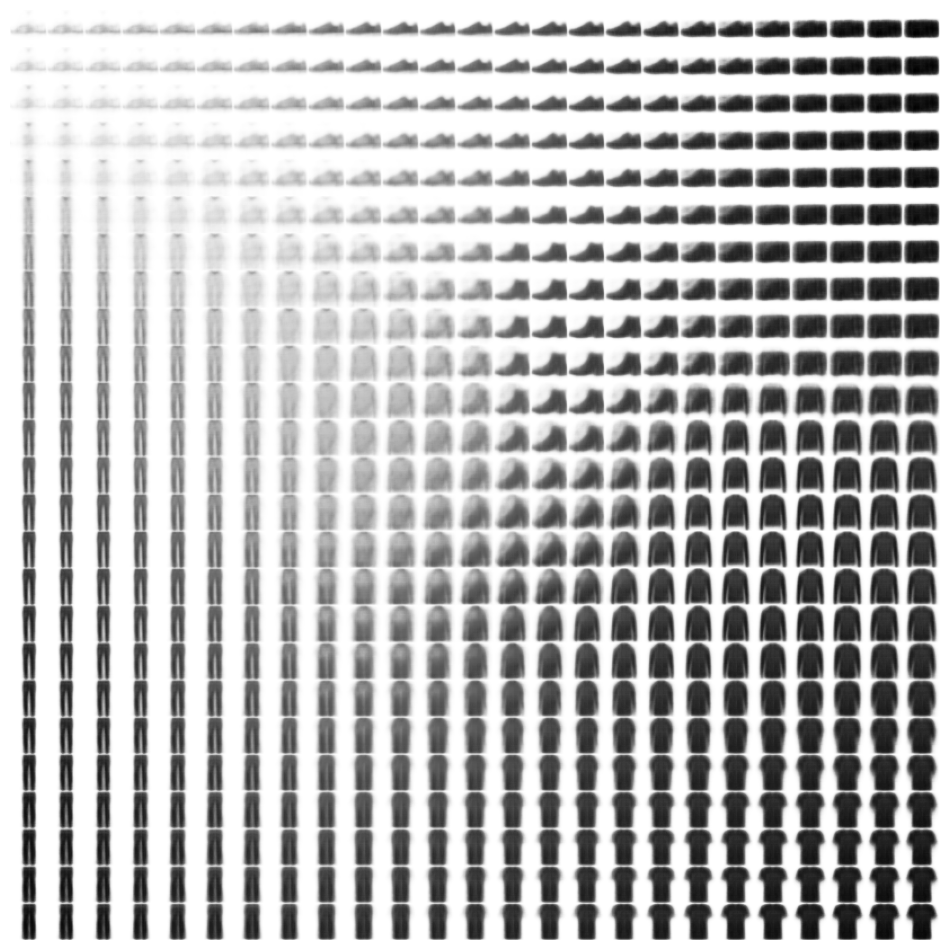

In [51]:
plot_reconstructed(model, xrange=(-2, 2), yrange=(-2, 2), N=25)

This latent space looks quite similar to the one using a VAE. This is not suprising, as when removing the information added from the one hot encoded label vector, the conditional VAE is in essence a normal VAE.

for one specific class (pants)

In [54]:
@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange,
    decoding latents and visualizing distribution of the space
    """
    SIZE = 33
    grid = np.empty((1,N*SIZE, N*SIZE))

    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(device)
            label = torch.zeros(1,10).to(device)
            label[0, 1] = 1
            x_hat = model.decoder((z, label)).cpu()
            x_hat = x_hat.view(1, 33,33)

            #if np.random.randint(0, high=2) == 1:
            #  x_hat = torch.zeros(3,257,257)

            grid[:,(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat

    grid = torch.tensor(grid)

    plt.figure(figsize=(12,20))
    plt.imshow(transforms.functional.to_pil_image(grid), extent=[*yrange, *xrange])#, cmap="gray")
    plt.axis("off")

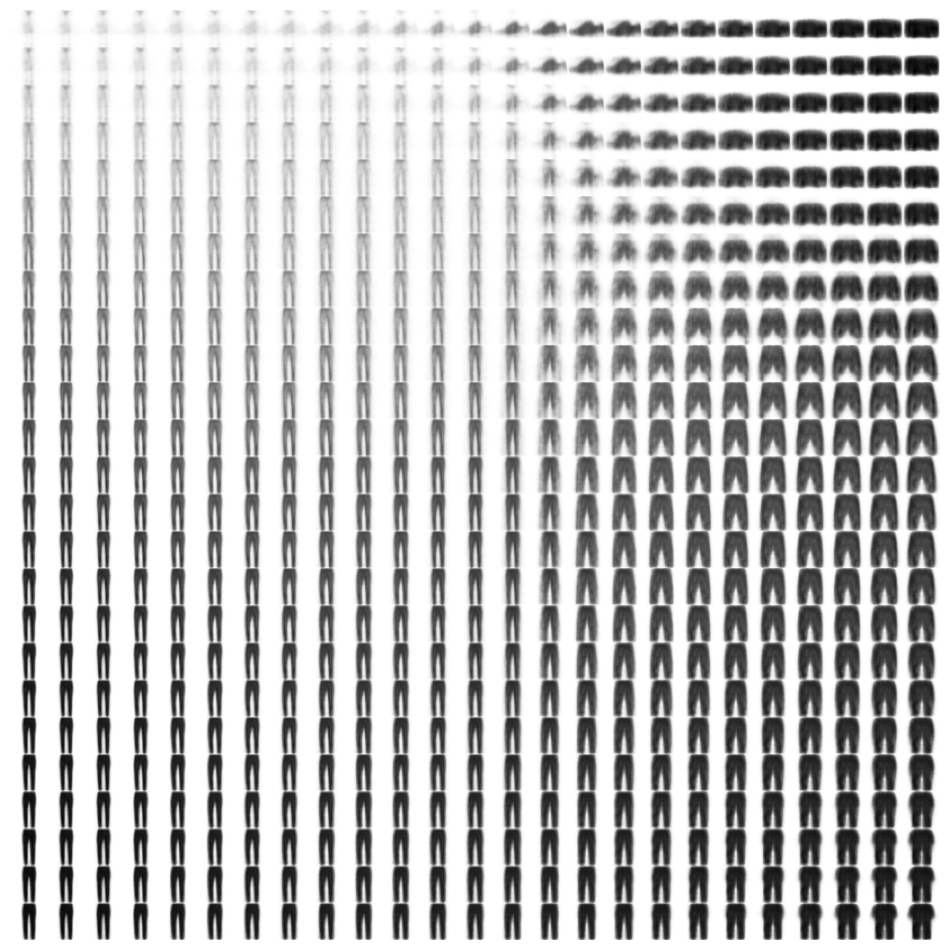

In [55]:
plot_reconstructed(model, xrange=(-2, 2), yrange=(-2, 2), N=25)

We can observe, that the model learned from the one hot encoded vector what pants are supposed to look like.

### Interpolate between images

first image

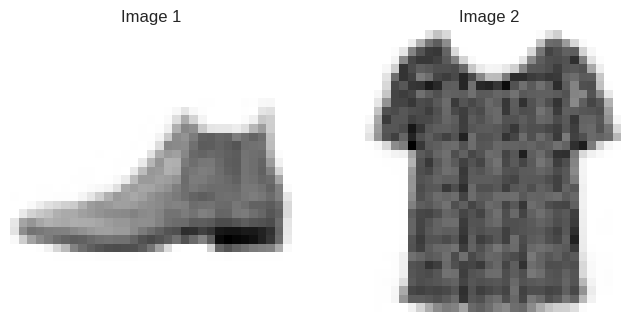

In [56]:
img1, label1, _ = test_dataset[0]
img2, label2, _ = test_dataset[1000]

plt.subplot(1,2,1)
plt.imshow(transforms.functional.to_pil_image(img1))
plt.axis("off")
plt.title(f"Image 1")
plt.subplot(1,2,2)
plt.imshow(transforms.functional.to_pil_image(img2))
plt.title(f"Image 2")
plt.axis("off")
plt.show()

In [57]:
with torch.no_grad():
    encoded = model.encoder((torch.stack([img1, img2]).to(device), torch.stack([label1, label2]).to(device)))
    #b_size,n_features = encoded.shape
    #encoded = encoded.reshape(b_size, n_channels*w*h)
    mus, log_var = model.fc_mu(encoded), model.fc_sigma(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

In [58]:
@torch.no_grad()
def sample_interpolation(model, p1, p2, N=15):
    """ Sampling N points from the line that connects p1 and p2 """

    z = torch.stack([p1 * t + p2 * (1-t) for t in torch.linspace(0, 1, N).to(device)])
    label = torch.stack([label1.to(device) * t + label2.to(device) * (1-t) for t in torch.linspace(0,1,N).to(device)])
    decoded = model.decoder ((z, label))
    decoded_imgs = decoded.cpu().view(-1,1,33,33)
    return decoded_imgs

In [59]:
decoded_imgs = sample_interpolation(model, latent2, latent1, N=12)

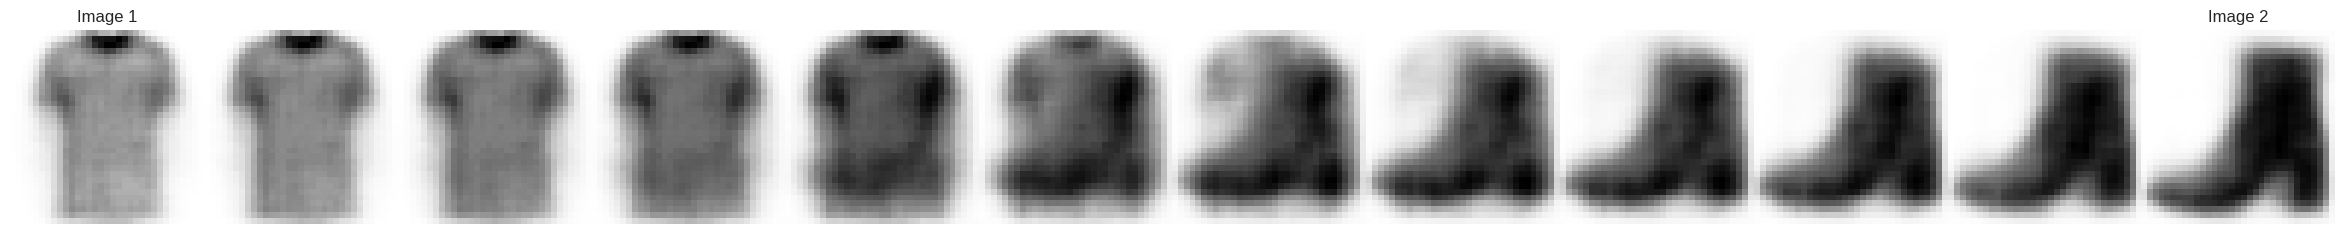

In [60]:
fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(transforms.functional.to_pil_image(img))#, cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()

other images

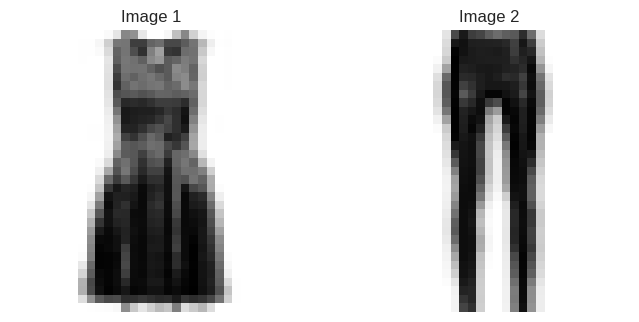

In [74]:
img1, label1, _ = test_dataset[259]
img2, label2, _ = test_dataset[137]

plt.subplot(1,2,1)
plt.imshow(transforms.functional.to_pil_image(img1))
plt.axis("off")
plt.title(f"Image 1")
plt.subplot(1,2,2)
plt.imshow(transforms.functional.to_pil_image(img2))
plt.title(f"Image 2")
plt.axis("off")
plt.show()

In [75]:
with torch.no_grad():
    encoded = model.encoder((torch.stack([img1, img2]).to(device), torch.stack([label1, label2]).to(device)))
    #b_size,n_features = encoded.shape
    #encoded = encoded.reshape(b_size, n_channels*w*h)
    mus, log_var = model.fc_mu(encoded), model.fc_sigma(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

In [76]:
@torch.no_grad()
def sample_interpolation(model, p1, p2, N=15):
    """ Sampling N points from the line that connects p1 and p2 """

    z = torch.stack([p1 * t + p2 * (1-t) for t in torch.linspace(0, 1, N).to(device)])
    label = torch.stack([label1.to(device) * t + label2.to(device) * (1-t) for t in torch.linspace(0,1,N).to(device)])
    decoded = model.decoder ((z, label))
    decoded_imgs = decoded.cpu().view(-1,1,33,33)
    return decoded_imgs

In [77]:
decoded_imgs = sample_interpolation(model, latent2, latent1, N=12)

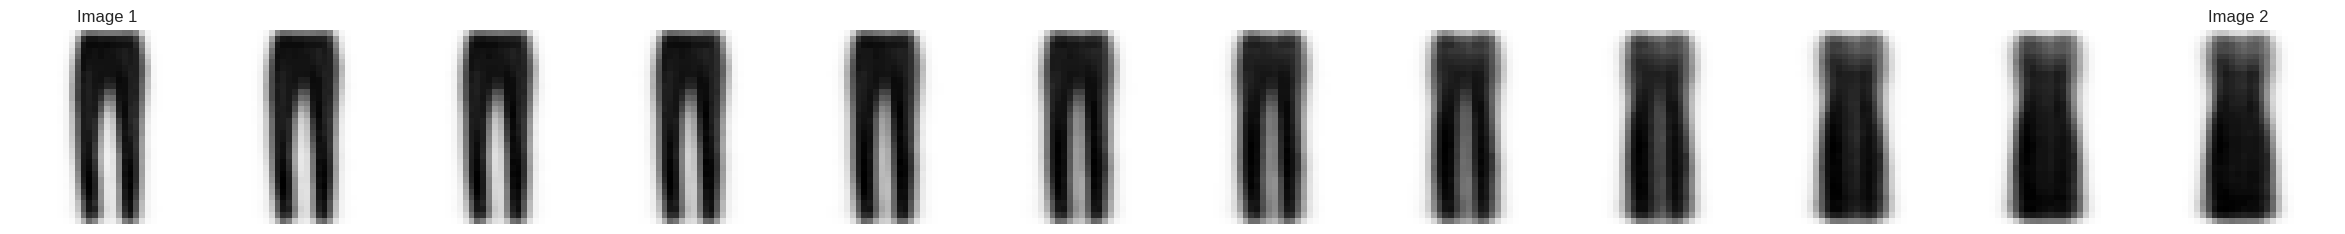

In [78]:
fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(transforms.functional.to_pil_image(img))#, cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()